# Monetary Aggregates

In [1]:
#Libraries
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import requests
from datetime import datetime
from pandas.io.json import json_normalize
import pickle
import os 
import sys
from IPython.core.pylabtools import figsize

In [2]:
#Number of daily simulations
steps=500
BlockPerDay=2*60*24 #blocks per day
BlocksPerYear=BlockPerDay*365
BlockRate=BlocksPerYear

In [3]:
#Initialize Variables
X1=np.zeros(steps) #Exchange Rate
X1[0]=0.0200422051185593
IAs1=np.zeros(steps)  #Interest accumulated supply
IAs1[0]=0 #
TS1=np.zeros(steps)  #Total Supply
TS1[0]=20 #Total ETH
TB1=np.zeros(steps)  #Total Borrows ETH
TB1[0]=2 #Total Borrows ETH
IAb1=np.zeros(steps)  #Interest accumulated borrow
IAb1[0]=0 #
TR1=np.zeros(steps) #Total Reserves
TR1[0]=2 #Total Reserves ETH
rateB1=np.zeros(steps) #Block Rate
rateB1[0]=0 #
rateS1=np.zeros(steps) #Block Rate
rateS1[0]=0 
SF1=np.zeros(steps) #Subsidy fund
SF1[0]=0
difSF1=np.zeros(steps) #Subsidy fund decrease
difSF1[0]=0

In [32]:
#Initialize Variables
X2=np.zeros(steps) #Exchange Rate
X2[0]=0.0200422051185593
IAs2=np.zeros(steps)  #Interest accumulated supply
IAs2[0]=0 #
TS2=np.zeros(steps)  #Total Supply
TS2[0]=20 #Total ETH
TB2=np.zeros(steps)  #Total Borrows ETH
TB2[0]=0.8 #Total Borrows ETH
IAb2=np.zeros(steps)  #Interest accumulated borrow
IAb2[0]=0 #
TR2=np.zeros(steps) #Total Reserves
TR2[0]=3 #Total Reserves ETH
rateB2=np.zeros(steps) #Block Rate
rateB2[0]=0 #
rateS2=np.zeros(steps) #Block Rate
rateS2[0]=0 #
SF2=np.zeros(steps) #Subsidy fund
SF2[0]=2
difSF2=np.zeros(steps) #Subsidy fund decrease
difSF2[0]=0

In [33]:
#Initial parameters and interest rate model
#I=np.array([1]) #Index
Delta=1
rF=0.2

#Utilization
def urate(S,B):
    if S>0:
        ur=B/S
    else:
        ur=0  
    return ur

Ut1=np.zeros(steps) #Utilization Rate
Ut1[0]=TB1[0]/TS1[0]
Ut2=np.zeros(steps) #Utilization Rate
Ut2[0]=TB2[0]/TS2[0]

Ut1[0]

0.1

## Interest Rate model Compound

In [34]:
#Functions interest rate model
def br1(u):
    alpha=0.02
    beta=0.183220300598734
    return alpha+beta*u
def sr1(u):
    alpha=0.02
    beta=0.183220300598734
    rF=0.2
    return u*(alpha+beta*u)*(1-rF)

In [35]:
Br1=np.zeros(steps) #Borrow Rate
Br1[0]=br1(TB1[0]/TS1[0])
Sr1=np.zeros(steps) #Supply Rate
Sr1[0]=sr1(TB1[0]/TS1[0])
#Mt=np.zeros(steps) #Multiplier
#Mt[0]=1

In [36]:
print('Borrow Rate',Br1[0])
print('Supply Rate',Sr1[0])

Borrow Rate 0.038322030059873405
Supply Rate 0.0030657624047898727


## Interest Rate linear model target 5%

In [37]:
#Functions interest rate model
def br2(u):
    alpha=0.08
    beta=0.04
    return alpha+beta*u
def sr2(u):
    alpha=0.05
    beta=0.02
    return alpha+beta*u

In [38]:
Br2=np.zeros(steps) #Borrow Rate
Br2[0]=br2(TB2[0]/TS2[0])
Sr2=np.zeros(steps) #Supply Rate
Sr2[0]=sr2(TB2[0]/TS2[0])
#Mt=np.zeros(steps) #Multiplier
#Mt[0]=1

In [39]:
print('Borrow Rate',Br2[0])
print('Supply Rate',Sr2[0])

Borrow Rate 0.0816
Supply Rate 0.050800000000000005


## Simulate Aggregates

In [40]:
#Simulate 1st steps

# a = % de prestamos pagados
# b = % de cash tomado en prestamos
# c = redeems
# d = supply realizados
def sim_agg(T,a=0.1,b=0.1,c=-3,d=5,MC=30):
#     Nio=np.random.uniform(low=0, high=2, size=T)# borrows ETH
#     Mio=np.random.uniform(low=-3, high=10, size=T) #supply ETH
# #     Nio=np.random.normal(loc=1,size=T)*2 # borrows ETH
# #     Mio=np.random.normal(size=T)*5 # supply ETH
#     tsa = 0
#     for a in range(len(Mio)):
#         if tsa + Mio[a] < MC:
#             tsa += Mio[a]
#         else: 
#             Mio[a] = 0
    Nio = np.zeros(T)
    Mio = np.zeros(T)
    tsa = TS2[0]
    for t in range(1, T):
        newNio = np.random.uniform(low = -TB2[t-1]*a, high = max(0, TS2[t-1]-TB2[t-1]+TR2[t-1])*b) # borrows ETH
        newMio = np.random.uniform(low = c, high = d) #supply ETH
        if tsa + newMio < MC:
            tsa += newMio
        else:
            newMio = 0
        Nio[t] = newNio
        Mio[t] = newMio
        #Interest rate model 1
        Ut1[t]=urate(TS1[t-1],TB1[t-1])  
        Br1[t]=br1(Ut1[t])
        Sr1[t]=sr1(Ut1[t])
        rateB1[t]=Br1[t]/BlockRate # RatePerBlock
        rateS1[t]=Sr1[t]/BlockRate
        IAb1[t]=IAb1[t-1]+TB1[t-1]*rateB1[t]*Delta
        TB1[t]=TB1[t-1]+IAb1[t]+Nio[t]
        TR1[t]=TR1[t-1]+TB1[t-1]*rateB1[t]*Delta*rF
        IAs1[t]=IAs1[t-1]+TS1[t-1]*rateS1[t]*Delta
        TS1[t]=TS1[t-1]+IAs1[t]+Mio[t]
        SF1[t] = SF1[t-1] - max(0, IAs1[t] - IAb1[t])
        difSF1[t] = max(0, IAs1[t] - IAb1[t])
        #Interest rate model 2
        Ut2[t]=urate(TS2[t-1],TB2[t-1])  
        Br2[t]=br2(Ut2[t])
        Sr2[t]=sr2(Ut2[t])
        rateB2[t]=Br2[t]/BlockRate
        rateS2[t]=Sr2[t]/BlockRate
        IAb2[t]=IAb2[t-1]+TB2[t-1]*rateB2[t]*Delta
        TB2[t]=TB2[t-1]+IAb2[t]+Nio[t]
        TR2[t]=TR2[t-1]+TB2[t-1]*rateB2[t]*Delta*rF
        IAs2[t]=IAs2[t-1]+TS2[t-1]*rateS2[t]*Delta
        TS2[t]=TS2[t-1]+IAs2[t]+Mio[t]
        SF2[t]= SF2[t-1] - max(0,IAs2[t] - IAb2[t])
        difSF2[t] = max(0, IAs2[t] - IAb2[t])        
        
    itm1=pd.DataFrame({'utilization':Ut1,'borrow rate':Br1,'Block brate':rateB1,'supply rate': Sr1,'Block srate': rateS1})
    itm2=pd.DataFrame({'utilization':Ut2,'borrow rate':Br2,'Block brate':rateB2,'supply rate': Sr2,'Block srate': rateS2})
    mAgg1=pd.DataFrame({'N.Borrow(ETH)':Nio,'T.Borrow(ETH)':TB1,'IA.Borrow(ETH)':IAb1,'N.Supply(ETH)':Mio,'T.Supply(ETH)':TS1,
                        'IA.Supply(ETH)':IAs1,'T.Reserves(ETH)': TR1,'Cash(ETH)':(TS1-TB1+TR1),'Subsidy(ETH)': SF1,
                        'DecreaseSubsidy(ETH)': difSF1})
    mAgg2=pd.DataFrame({'N.Borrow(ETH)':Nio,'T.Borrow(ETH)':TB2,'IA.Borrow(ETH)':IAb2,'N.Supply(ETH)':Mio,'T.Supply(ETH)':TS2,
                        'IA.Supply(ETH)':IAs2,'T.Reserves(ETH)': TR2,'Cash(ETH)':(TS2-TB2+TR2),'Subsidy(ETH)': SF2,
                        'DecreaseSubsidy(ETH)': difSF2})
    return itm1,mAgg1,itm2,mAgg2

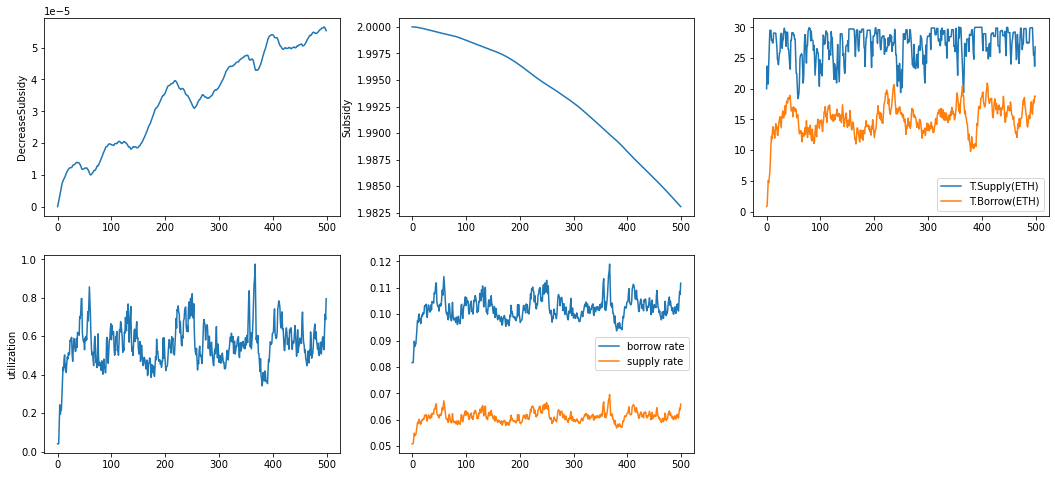

In [41]:
(itm1,mAgg1,itm2,mAgg2)=sim_agg(steps)

figsize(18,8)

plt.subplot(2,3,1)
plt.plot(mAgg2["DecreaseSubsidy(ETH)"])
plt.ylabel('DecreaseSubsidy')

plt.subplot(2,3,2)
plt.plot(mAgg2["Subsidy(ETH)"])
plt.ylabel('Subsidy')

plt.subplot(2,3,3)
plt.plot(mAgg2["T.Supply(ETH)"],label = "T.Supply(ETH)")
plt.plot(mAgg2["T.Borrow(ETH)"],label = "T.Borrow(ETH)")
plt.legend()

plt.subplot(2,3,4)
plt.plot(itm2["utilization"])
plt.ylabel('utilization')

plt.subplot(2,3,5)
plt.plot(itm2["borrow rate"],label = "borrow rate")
plt.plot(itm2["supply rate"],label = "supply rate")
plt.legend()

plt.show()

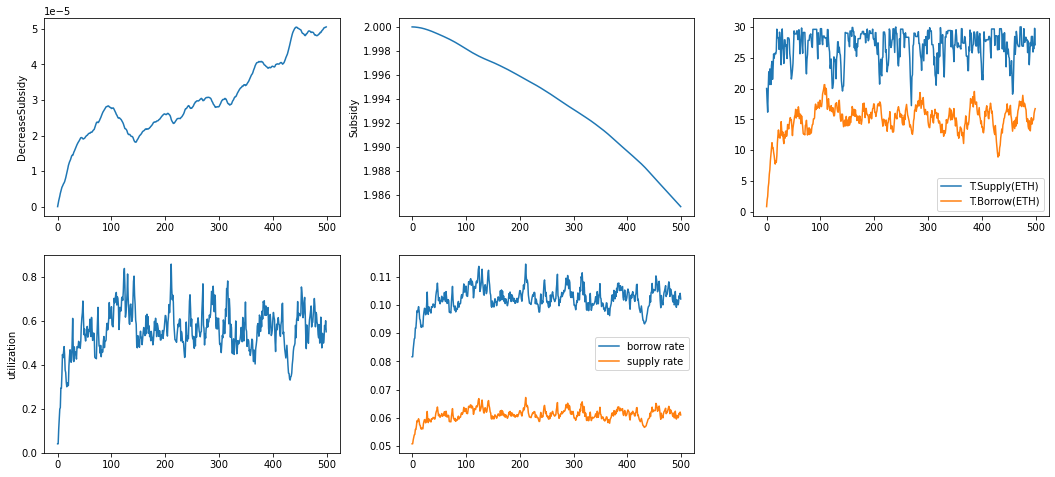

In [55]:
(itm1,mAgg1,itm2,mAgg2)=sim_agg(steps)

figsize(18,8)

plt.subplot(2,3,1)
plt.plot(mAgg2["DecreaseSubsidy(ETH)"])
plt.ylabel('DecreaseSubsidy')

plt.subplot(2,3,2)
plt.plot(mAgg2["Subsidy(ETH)"])
plt.ylabel('Subsidy')

plt.subplot(2,3,3)
plt.plot(mAgg2["T.Supply(ETH)"],label = "T.Supply(ETH)")
plt.plot(mAgg2["T.Borrow(ETH)"],label = "T.Borrow(ETH)")
plt.legend()

plt.subplot(2,3,4)
plt.plot(itm2["utilization"])
plt.ylabel('utilization')

plt.subplot(2,3,5)
plt.plot(itm2["borrow rate"],label = "borrow rate")
plt.plot(itm2["supply rate"],label = "supply rate")
plt.legend()

plt.show()

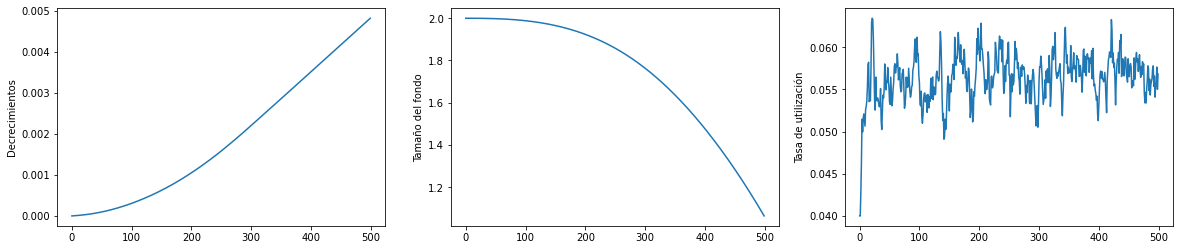

In [57]:
n = 100 # Cantidad de simulaciones
a = 0.5; b = 0.03; c = -3; d = 5; MC=300
dif = []; SF = []; UR = []
for i in range(n):
    (itm1,mAgg1,itm2,mAgg2)=sim_agg(steps, a, b, c, d, MC)
    dif.append(mAgg2["DecreaseSubsidy(ETH)"])
    SF.append(mAgg2["Subsidy(ETH)"])
    UR.append(itm2["utilization"])
    
promDif = sum(dif)/len(dif)
promSF = sum(SF)/len(SF)
promUR = sum(UR)/len(UR)

# figsize(16,4)
figsize(20,4)

plt.subplot(1,3,1)
plt.plot(promDif)
plt.ylabel("Decrecimientos")

plt.subplot(1,3,2)
plt.plot(promSF)
plt.ylabel("Tamaño del fondo")

plt.subplot(1,3,3)
plt.plot(promUR)
plt.ylabel("Tasa de utilización")

plt.show()

In [58]:
# pd.set_option("display.precision", 10)
# itm1

In [59]:
# pd.set_option("display.precision", 10)
# itm2

In [60]:
# pd.set_option("display.precision", 10)
# mAgg1

In [61]:
# pd.set_option("display.precision", 10)
# mAgg2

In [62]:
mean = sum(mAgg2["T.Supply(ETH)"])/len(mAgg2["T.Supply(ETH)"])
totalMarket = mean/0.25
print(mean,totalMarket)

229.22745547938104 916.9098219175241


In [63]:
print(mean*35000,totalMarket*35000)

8022960.941778337 32091843.767113347


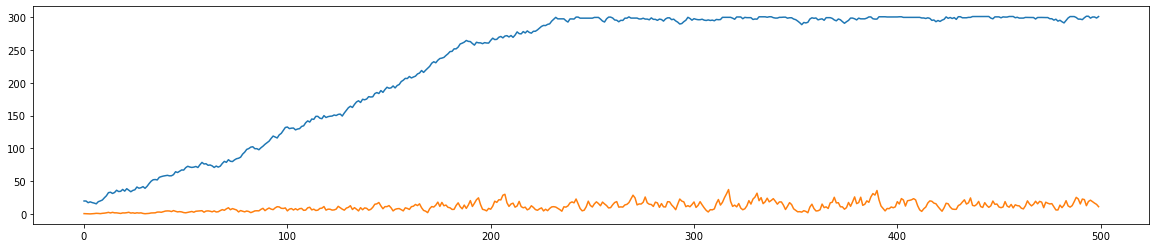

In [65]:
plt.plot(mAgg2["T.Supply(ETH)"])
plt.plot(mAgg2["T.Borrow(ETH)"])